**성능 평가 지표(Evaluation Metric)**
- 모델에 따라(분류/회귀) 여러 종류로 나뉨
- 분류
    - 정확도
    - 오차행렬
    - 정밀도
    - 재현율
    - F1 스코어
    - ROC AUC

### 1. 정확도(Accuracy)
- 실제 데이터에서 예측 데이터가 얼마나 같은지 판단하는 지표
- 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 직관적으로 모델 예측 성능 나타내는 평가 지표
- 이진 분류의 경우 데이터 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치만으로 성능을 평가하지 않음

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습히지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 아니면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
cd ./data

C:\Users\samsung\판다스 스터디\data


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
accuracy_score(y_test, mypredictions)

0.7877094972067039

- 단순 알고리즘으로 예측시에도 데이터 구성에 따라 정확도 결과가 높게 나올 수 있으므로 정확도를 평가 지표로 사용할 때는 매우 신중해야함
- 특히 불균형한 레이블 값 분포에서 ML 모델의 성능 판단 시 적합한 평가 지표가 아님

In [6]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    # 입력 값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
digits = load_digits()

# digits 번호가 7이면 True 이고 1로 변환, 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [7]:
y_test.shape

(450,)

In [8]:
pd.Series(y_test).value_counts()

0    405
1     45
dtype: int64

In [9]:
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
accuracy_score(y_test, fakepred)

0.9

### 2. 오차 행렬(Confusion Matrix)
- 이진 분류에서 성능 지표로 잘 활용됨
- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
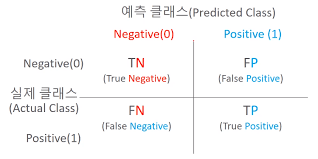
- True : 예측 클래스 값 == 실제 클래스 값
- Negative : 예측값 == Negative   
- TN : 예측값이 Negative 이고 실제 값도 Negative
- FP : 예측값이 Positive 이고 실제 값은 Negative
- FN : 예측값이 Negative 이고 실제 값은 Positive
- TP : 예측값이 Positive 이고 실제 값도 Positive

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

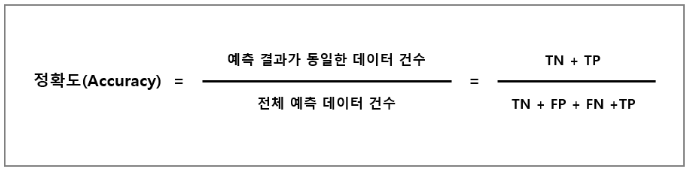

- 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 중점적으로 찾아야하는 적은 수의 결과값을 Positive(1), 그렇지 않은 경우를 Negative(0)으로 설정하는 경우가 많음
- 이러한 경우 Positive 데이터 건수가 매우 작기 때문에 Negative로 예측 정확도가 높아지는 경향이 발생함(TN↑, TP↓)

### 3. 정밀도와 재현율

- Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

**정밀도**
- TP/(FP+TP)
- 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율
- 양성 예측도
- FP 낮추는 데 초점

**재현율**
- TP/(FN+TP)
- 실제 값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한데이터의 비율
- 민감도,TPR   
- FN 낮추는 데 초점
- 재현율이 중요 지표인 경우
    - 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무에 큰 영향이 발생하는 경우
    - 암 판단 모델, 금융 사기 적발 모델 등
- 정밀도가 중요 지표인 경우
    - 실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 업무에 큰 영향이 발생하는 경우
    - 스팸메일 여부 판단
- 정밀도와 재현율은 서로 보완적인 지표로 분류 성능 평가하는 데 적용됨.
- 둘 다 높은 수치를 얻는 것이 가장 좋음

In [11]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [12]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(solver = 'liblinear') # 기본값 : lbfgs , 데이터가 상대적으로 크고 다중 분류인 경우 적합
# liblinear : 작은 데이터 세트의 이진 분류인 경우 성능이 약간 더 좋은 경향이 있음
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


#### 정밀도/재현율 트레이드오프
- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 하는 경우   
    → 분류의 결정 임계값(Threshold)을 조정해 정밀도 또는 재현율 높일 수 있음
- 트레이드오프 -> 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지는 현상

In [13]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(pred_proba.shape)
print('pred_proba array에서 앞 3개만 샘플로 추출:',pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 클래스 중 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

(179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
두 클래스 중 더 큰 확률을 클래스 값으로 예측 
 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [14]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]
# 지정된 threshold보다 같거나 작으면 0, 크면 1로 변환함.
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
# predict()가 predict_proba()에 기반함을 확인

custom_threshold = 0.5

# Positive 클래스 칼럼만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


In [16]:
# threshold 낮추기

custom_threshold = 0.4

# Positive 클래스 칼럼만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
# 재현율이 올라가고 정밀도가 감소함
# 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이 되므로 임계값을 낮추면 Positive로 예측을 더 너그럽게 함.

오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197


In [58]:
# 임계값 증가시켜보기
thresholds = [0.4, 0.45, 0.4, 0.55, 0.6]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[80 20]
 [17 37]]
정확도:0.7597, 정밀도:0.6491, 재현율:0.6852, F1:0.6667
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857
임곗값: 0.4
오차 행렬
[[80 20]
 [17 37]]
정확도:0.7597, 정밀도:0.6491, 재현율:0.6852, F1:0.6667
임곗값: 0.55
오차 행렬
[[91  9]
 [23 31]]
정확도:0.7922, 정밀도:0.7750, 재현율:0.5741, F1:0.6596
임곗값: 0.6
오차 행렬
[[91  9]
 [26 28]]
정확도:0.7727, 정밀도:0.7568, 재현율:0.5185, F1:0.6154


In [53]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape:',thresholds.shape)

# 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print(thr_index)
print(np.round(thresholds[thr_index],2))

print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 shape: (124,)
[  0  15  30  45  60  75  90 105 120]
[0.11 0.14 0.21 0.29 0.35 0.46 0.66 0.78 0.9 ]
샘플 임계값별 정밀도: [0.435 0.486 0.532 0.557 0.609 0.714 0.794 0.789 0.75 ]
샘플 임계값별 재현율: [1.    0.981 0.926 0.815 0.722 0.648 0.5   0.278 0.056]


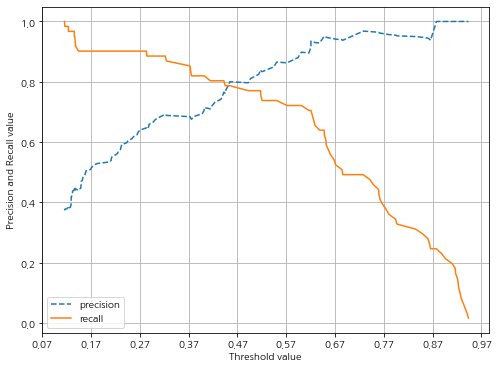

In [20]:
# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])
# 정밀도는 점선, 재현율은 실선

#### 정밀도와 재현율의 맹점
- 임계값의 변경은 업부 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 함

**정밀도 100% 되는 법**
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측하기

**재현율 100% 되는 법**
- 모든 환자 Positive로 예측

- 둘 중 하나의 스코어만 좋은 경우 성능이 좋지 않은 분류로 간주할 수 있음

### 4. F1 스코어
- 정밀도와 재현율 결합한 지표
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값 가짐

- F1 = 2*(precision * recall)/(precision + recall)

In [21]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [57]:
# 임계값 별 정밀도, 재현율, F1 스코어
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[80 20]
 [17 37]]
정확도:0.7597, 정밀도:0.6491, 재현율:0.6852, F1:0.6667
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804
임곗값: 0.55
오차 행렬
[[91  9]
 [23 31]]
정확도:0.7922, 정밀도:0.7750, 재현율:0.5741, F1:0.6596
임곗값: 0.6
오차 행렬
[[91  9]
 [26 28]]
정확도:0.7727, 정밀도:0.7568, 재현율:0.5185, F1:0.6154


### 5. ROC 곡선과 AUC
- 이진 분류의 예측 성능에서 중요하게 사용되는 지표
- ROC 곡선(Receiver Operation Characteristic Curve) : 수신자 판단 곡선
- FPR이 변할 때 TPR(=재현율=민감도)이 어떻게 변하는지 나타내는 곡선
- TPR : 실제 Positive가 정확이 예측돼야 하는 수준 나타냄
- TNR(특이성) : 실제 Negative가 정확히 예측돼야 하는 수준 나타냄
     - TNR = TN / (FP + TN)
     - FPR = 1 - TNR
- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지고 멀어질수록 성능이 뛰어남

In [25]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# thresholds[0]은 max(예측확률) + 1 로 임의로 설정됨.
thr_index = np.arange(1, thresholds.shape[0],5)
print(thr_index)
print(np.round(thresholds[thr_index],2))

print('샘플 임계값 별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임계값 별 TPR:', np.round(tprs[thr_index],3))
# 임계값이 점점 작아지면서 FPR은 점점 커지고 , FPR이 조금씩 커질 때 마다 TPR은 가파르게 커짐

[ 1  6 11 16 21 26 31 36 41 46]
[0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값 별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값 별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


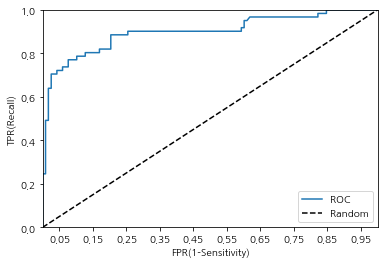

In [26]:
# ROC 곡선 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    fprs,tprs,thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])
# AUC(Area Under Curve) : ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋음
# AUC가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는지가 관건임

In [28]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print(roc_score)

0.8986524034454015


In [64]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 6. 피마 인디언 당뇨병 예측

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)
# Negative가 상대적으로 많음

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [31]:
diabetes_data.info()
# Null 없음, 모두 숫자형
# 별도의 피처 인코딩은 필요하지 않아 보임

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [34]:
# 로지스틱 회귀로 예측모델 생성
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)
# 전체 데이터의 65%가 Negative 이므로 재현율 성능에 초점을 맞춤

오차 행렬
[[87 13]
 [22 32]]
정확도:0.7727, 정밀도:0.7111, 재현율:0.5926, F1:0.6465, ACU:0.8083


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


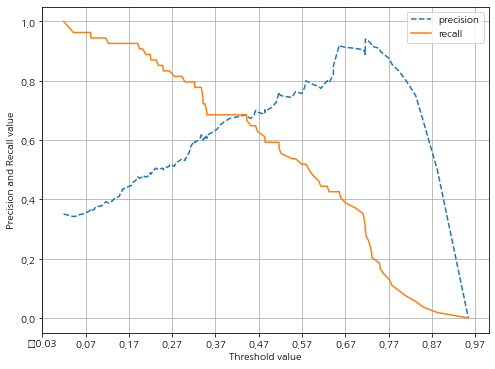

In [36]:
# 정밀도 재현율 곡선
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)
# 임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같음.
# 하지만 두 지표 모두 0.7도 안되는 수치이므로 데이터 값 점검 필요

In [38]:
# 피처 값 분포도 살펴보기
diabetes_data.describe()
# min 값이 0인 피처가 상당히 많음
# Glucose 등 값이 0이면 안되는 피처들이 존재

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


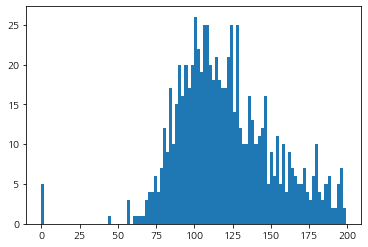

In [39]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()
# 0인 값 5개 존재

In [43]:
# min() 이 0인 피처에 대해 0값 건수 및 전체 데이터 건수 대비 비율 확인
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트 0.65 %
BloodPressure 0 건수는 35, 퍼센트 4.56 %
SkinThickness 0 건수는 227, 퍼센트 29.56 %
Insulin 0 건수는 374, 퍼센트 48.70 %
BMI 0 건수는 11, 퍼센트 1.43 %


In [45]:
# 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [47]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test  = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)
# 성능 수치가 일정 수준 개선됏지만 재현율 수치의 개선이 여전히 필요해보임

오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, ACU:0.8433


In [59]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)
# 임계값이 0.48인 경우가 가장 좋은 임계값으로 보임

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963, F1:0.6615
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778, F1:0.6774
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222, F1:0.6667
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037, F1:0.6667
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667, F1:0.6792
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804


In [65]:
# 임계값 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433
